This is the same data as zillow_main, but I will be taking extra features into account here to see if there is a significant difference.

In [1]:
import pandas as pd
import numpy as np
from env import get_db_url
import evaluate, split_scale
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.formula.api import ols
from math import sqrt

In [2]:
url = get_db_url('zillow')
query = ('''
SELECT *
FROM properties_2017
JOIN predictions_2017 USING (parcelid)
WHERE propertylandusetypeid = 261
    AND (transactiondate >= '2017-05-01' AND 
         transactiondate <= '2017-06-31')
''')
df_orig = pd.read_sql(query, url)

In [3]:
counties = pd.read_table('FIPS.txt', header=1)
counties.columns = ['FIPS', 'county', 'state']
counties.head()

,FIPS,county,state
0,1001,Autauga,AL
1,1003,Baldwin,AL
2,1005,Barbour,AL
3,1007,Bibb,AL
4,1009,Blount,AL


In [4]:
df = df_orig.copy()
df.head(10)

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate
0,11289917,2061546,1.0,NaN,NaN,2.0,3.0,None,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
1,11705026,1834372,NaN,NaN,NaN,1.0,2.0,None,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30
2,14269464,1923117,NaN,NaN,NaN,3.0,4.0,None,NaN,3.0,...,880456.0,2016.0,445569.0,9819.72,None,NaN,6.059064e+13,2028,0.021085,2017-06-01
3,11389003,2121349,NaN,NaN,NaN,2.0,3.0,None,6.0,2.0,...,614000.0,2016.0,449000.0,7673.19,None,NaN,6.037703e+13,3273,-0.325393,2017-06-01
4,11967869,2093710,NaN,NaN,NaN,1.0,2.0,None,5.0,1.0,...,274237.0,2016.0,191821.0,3267.47,None,NaN,6.037185e+13,3429,-0.005566,2017-06-29
5,11696784,496818,NaN,NaN,NaN,0.0,0.0,None,NaN,NaN,...,168828.0,2016.0,127691.0,2135.39,None,NaN,6.037235e+13,3908,-0.124790,2017-06-16
6,14236060,2964522,NaN,NaN,NaN,2.0,3.0,None,NaN,2.0,...,196483.0,2016.0,85503.0,2376.34,None,NaN,6.059076e+13,5931,-0.088701,2017-05-19
7,14365030,1175489,NaN,NaN,NaN,2.5,3.0,None,NaN,2.5,...,605000.0,2016.0,434624.0,6185.28,None,NaN,6.059052e+13,6926,0.063343,2017-05-01
8,14008322,950579,NaN,NaN,NaN,1.0,3.0,None,NaN,1.0,...,141875.0,2016.0,109083.0,2015.78,None,NaN,6.059088e+13,7018,-0.047948,2017-05-18
9,11552513,570983,NaN,NaN,NaN,2.0,3.0,None,6.0,2.0,...,486866.0,2016.0,389499.0,5990.50,None,NaN,6.037271e+13,7085,-0.226048,2017-05-17


In [5]:
# df = pd.merge(df, counties, left_on='fips', 
#                  right_on='FIPS', how='left')
# df.drop(columns='fips', inplace=True)
# df.head()

In [6]:
df.dropna(thresh=2000, axis=1, inplace=True)

In [7]:
df.drop(columns=['garagecarcnt','airconditioningtypeid','pooltypeid7',
                 'buildingqualitytypeid','heatingorsystemtypeid',
                'propertyzoningdesc','regionidneighborhood',
                'threequarterbathnbr','unitcnt','id','logerror',
                'parcelid','assessmentyear','latitude','longitude',
                'finishedsquarefeet12','rawcensustractandblock',
                'transactiondate','fullbathcnt','regionidcity',
                'regionidcounty','regionidzip','calculatedbathnbr',
                'propertylandusetypeid','censustractandblock',
                'propertycountylandusecode','structuretaxvaluedollarcnt',
                'landtaxvaluedollarcnt', 'taxamount'],inplace=True)

In [8]:
df.shape

(15036, 12)

In [9]:
df.fireplacecnt = df.fireplacecnt.fillna(value=0)

In [10]:
df.poolcnt = df.poolcnt.fillna(value=0)

In [11]:
df.numberofstories = df.numberofstories.fillna(value=1)

In [12]:
df.garagetotalsqft = df.garagetotalsqft.fillna(value=0)

In [13]:
df.isnull().sum()

bathroomcnt                       0
bedroomcnt                        0
calculatedfinishedsquarefeet     24
fips                              0
fireplacecnt                      0
garagetotalsqft                   0
lotsizesquarefeet               104
poolcnt                           0
roomcnt                           0
yearbuilt                        41
numberofstories                   0
taxvaluedollarcnt                 0
dtype: int64

In [14]:
df.shape

(15036, 12)

In [15]:
df.dropna(inplace=True)
df.shape

(14893, 12)

In [16]:
train, test = split_scale.split_my_data(df, .8)
train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fireplacecnt,garagetotalsqft,lotsizesquarefeet,poolcnt,roomcnt,yearbuilt,numberofstories,taxvaluedollarcnt
1909,2.0,3.0,1178.0,6059.0,0.0,430.0,6354.0,1.0,6.0,1958.0,1.0,537000.0
3018,6.0,7.0,4438.0,6037.0,0.0,0.0,28094.0,1.0,0.0,1923.0,1.0,1147997.0
9384,4.0,4.0,3686.0,6059.0,0.0,473.0,7620.0,1.0,8.0,2000.0,1.0,1066240.0
3382,2.5,4.0,2499.0,6059.0,1.0,546.0,14580.0,0.0,8.0,1979.0,2.0,320447.0
5829,2.0,3.0,1759.0,6037.0,0.0,0.0,7420.0,0.0,0.0,1989.0,1.0,138768.0


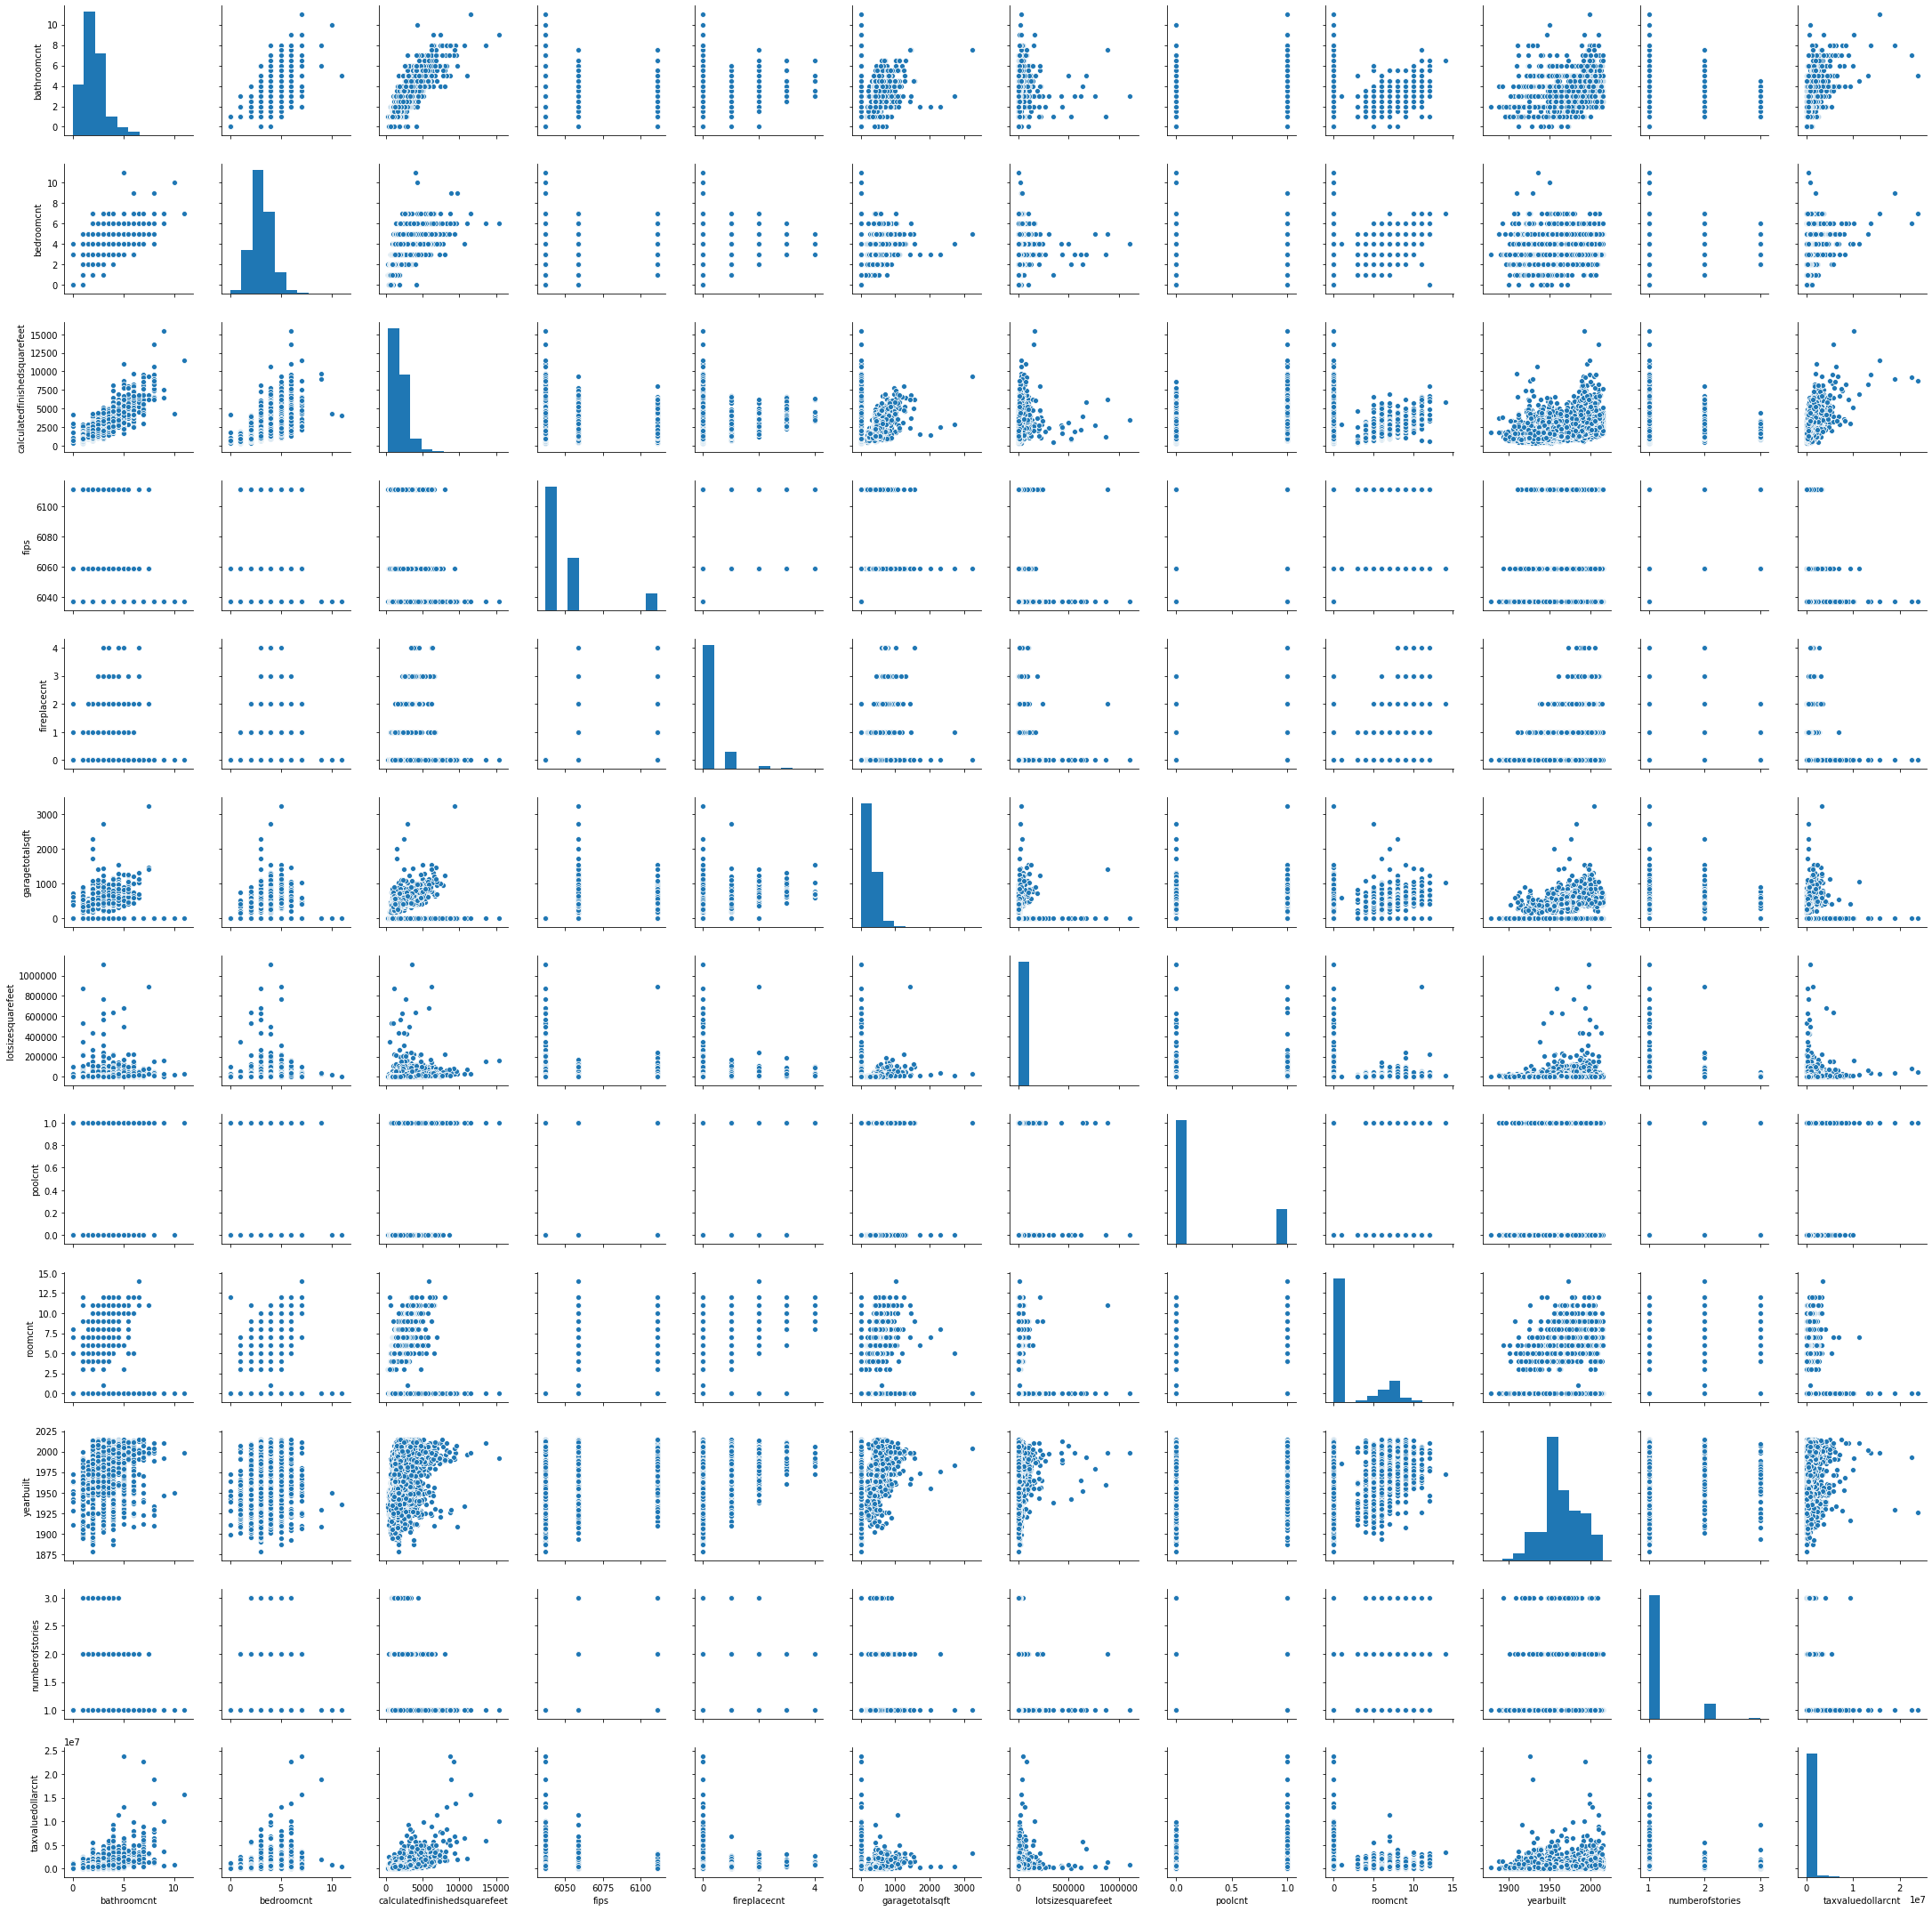

In [17]:
sns.pairplot(train)

In [18]:
train.taxvaluedollarcnt.max()

23858374.0

In [19]:
X_train = train.drop(columns='taxvaluedollarcnt')
y_train = train.taxvaluedollarcnt

In [20]:
selector = SelectKBest(f_regression, k=4)
selector.fit(X_train, y_train)
X2 = selector.transform(X_train)

support = selector.get_support()
X_train.columns[support].tolist()

['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'poolcnt']

In [21]:
rfe = RFE(LinearRegression(), 5)
X_rfe = rfe.fit_transform(X_train, y_train)
mask = rfe.support_
X_train.columns[mask].tolist()

['bathroomcnt', 'bedroomcnt', 'fireplacecnt', 'poolcnt', 'numberofstories']

In [22]:
predictions = pd.DataFrame({'actual': train.taxvaluedollarcnt})
predictions.head()

,actual
1909,537000.0
3018,1147997.0
9384,1066240.0
3382,320447.0
5829,138768.0


In [23]:
predictions['base_average'] = train.taxvaluedollarcnt.mean()
predictions.base_average = predictions.base_average.astype(int)
predictions.head()

,actual,base_average
1909,537000.0,538590
3018,1147997.0,538590
9384,1066240.0,538590
3382,320447.0,538590
5829,138768.0,538590


In [24]:
simple_lm_all = LinearRegression()
simple_lm_all.fit(X_train, y_train)
predictions['simple_lm_all'] = simple_lm_all.predict(X_train)
predictions.simple_lm_all = predictions.simple_lm_all.astype(int)
predictions.head()

,actual,base_average,simple_lm_all
1909,537000.0,538590,235167
3018,1147997.0,538590,1814615
9384,1066240.0,538590,1384754
3382,320447.0,538590,554110
5829,138768.0,538590,365679


In [25]:
X = train[['bathroomcnt', 'bedroomcnt', 
           'calculatedfinishedsquarefeet','poolcnt', ]]

simple_lm_k4 = LinearRegression()
simple_lm_k4.fit(X, y_train)
predictions['simple_lm_k4'] = simple_lm_k4.predict(X)
predictions.simple_lm_k4 = predictions.simple_lm_k4.astype(int)
predictions.head()

,actual,base_average,simple_lm_all,simple_lm_k4
1909,537000.0,538590,235167,208483
3018,1147997.0,538590,1814615,1424027
9384,1066240.0,538590,1384754,1395081
3382,320447.0,538590,554110,718246
5829,138768.0,538590,365679,476770


In [26]:
lm_rfe = LinearRegression()
rfe_use = RFE(lm_rfe, 5)
rfe_use.fit(X_train, y_train)
X_rfe = rfe_use.transform(X_train)
lm_rfe.fit(X_rfe, y_train)

predictions['rfe'] = lm_rfe.predict(X_rfe)
predictions.rfe = predictions.rfe.astype(int)
predictions.head()

,actual,base_average,simple_lm_all,simple_lm_k4,rfe
1909,537000.0,538590,235167,208483,540137
3018,1147997.0,538590,1814615,1424027,1867420
9384,1066240.0,538590,1384754,1395081,1281115
3382,320447.0,538590,554110,718246,438170
5829,138768.0,538590,365679,476770,417060


In [27]:
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda c: sqrt(mse(predictions.actual, c)))

actual               0.000
base_average    739811.999
simple_lm_all   571478.786
simple_lm_k4    579277.695
rfe             628860.768
dtype: float64

In [28]:
X_test = test.drop(columns='taxvaluedollarcnt')
y_test = test.taxvaluedollarcnt

In [29]:
X_test_k4 = test[['bathroomcnt', 'bedroomcnt', 
               'calculatedfinishedsquarefeet', 'poolcnt']]
y_test_predictions_k4 = simple_lm_k4.predict(X_test_k4)

k3_rmse = sqrt(mse(y_test, y_test_predictions_k4))
k3_rmse

545401.6131627586

In [30]:
X_test_rfe = test[['bathroomcnt', 'bedroomcnt', 'fireplacecnt', 
 'poolcnt', 'numberofstories']]
y_test_predictions_rfe = lm_rfe.predict(X_test_rfe)

rfe_rmse = sqrt(mse(y_test, y_test_predictions_rfe))
rfe_rmse

579864.3660154415

In [31]:
model = ols('y_test ~ X_test', data=test).fit()
r2, p = evaluate.model_significance(model)
r2, p

(0.3826718796714167, 8.14661957040391e-301)

In [32]:
model = ols('y_test ~ X_test_k4', data=test).fit()
r2, p = evaluate.model_significance(model)
r2, p

(0.37020759370433265, 1.4063965309944695e-296)

In [33]:
model = ols('y_test ~ X_test_rfe', data=test).fit()
r2, p = evaluate.model_significance(model)
r2, p

(0.28440653434956564, 6.007902687940127e-213)

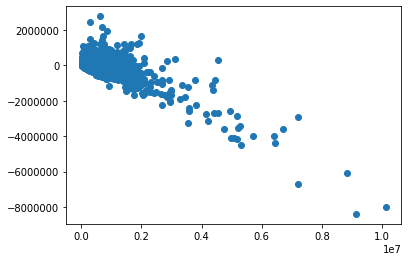

In [34]:
evaluate.plot_residuals(y_test, y_test_predictions_k4)

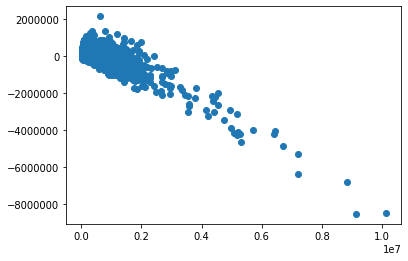

In [35]:
evaluate.plot_residuals(y_test, y_test_predictions_rfe)

After having tried multiple combinations of kbest and RFE models, these were the two that seemed best. Looking at them, there is very little difference in using all these extra features, so that likely means there is still a piece of data that is missing or not being taken into account, or that this data needs a nonlinear model to be most accurate. If I had to guess, looking at the pairplot above, multiple factors were just not counted in many houses, so when I replaced NULLs with minimum numbers, that misrepresented the data